In [7]:
# data augment with non-sales

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
train_discrete = np.loadtxt('train_discrete.csv', dtype=np.int32, delimiter=",")
train_continuous = np.loadtxt('train_continuous.csv', dtype=np.float32, delimiter=",")
train_y = np.loadtxt('train_y.csv', dtype=np.float32, delimiter=",")

In [3]:
val_discrete = np.loadtxt('val_discrete.csv', dtype=np.int32, delimiter=",")
val_continuous = np.loadtxt('val_continuous.csv', dtype=np.float32, delimiter=",")
val_y = np.loadtxt('val_y.csv', dtype=np.float32, delimiter=",")

In [4]:
test_discrete = np.loadtxt('test_discrete.csv', dtype=np.int32, delimiter=",")
test_continuous = np.loadtxt('test_continuous.csv', dtype=np.float32, delimiter=",")
test_id = np.loadtxt('test_id.csv', dtype=np.float32, delimiter=",")

In [5]:
train_continuous = np.reshape(train_continuous,(-1,1))
val_continuous = np.reshape(val_continuous,(-1,1))
test_continuous = np.reshape(test_continuous,(-1,1))

In [6]:
# clip negative sales
val_y[val_y<0] = .0
train_y[train_y<0] = .0

In [7]:
# standardize oil price
mean = np.mean(train_continuous)
std = np.std(train_continuous)
train_continuous = (train_continuous - mean)/std
val_continuous = (val_continuous - mean)/std
test_continuous = (test_continuous - mean)/std

In [119]:
# use the most recent time representation
val_discrete[:,6] = 54
test_discrete[:,6] = 54

In [8]:
def batch_iterator(discrete,continuous,y,batch_size,shuffle=True):
    # return a list of variables
    n = discrete.shape[0]
    index = np.random.permutation(n) if shuffle else range(n)
    from_ = 0
    for i in range(n//batch_size):
        temp_index = index[from_:from_+batch_size]
        w_ = np.ones(batch_size)
        w_[discrete[temp_index,14]==1] = 1.25 # perishable
        yield list(discrete[temp_index].T)\
                + [continuous[temp_index]\
                       ,w_,y[temp_index]]
        from_ += batch_size

** Build Computational Graph **

cardinalitys = np.max(train_discrete,0) + 1

In [212]:
cardinalitys = [55, 3998, 3, 7, 2, 13, 55, 2, 7, 4, 25, 2, 34, 256, 2, 23, 17, 6, 18]
dimentions = [10, 10, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
lambdas = np.array([2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1e-5 # regularization coefficient
l1,l2,l3 = 1e-5,1e-5,1e-5
d = sum(dimentions)
batch_size = 1000
learning_rate = 1e-4
epoch = 1

In [213]:
tf.reset_default_graph()

In [214]:
embeddings = [tf.get_variable("embedding_"+str(i), [car, dim],initializer=tf.truncated_normal_initializer()) \
                for i,(car,dim) in enumerate(zip(cardinalitys,dimentions))]

In [215]:
X_discretes = [tf.placeholder(tf.int32, [batch_size,], name='X_discrete_'+str(i)) for i,_ in enumerate(dimentions)]
X_continuous = tf.placeholder(tf.float32, [batch_size,1], name='X_continuous')
Weight = tf.placeholder(tf.float32, [batch_size,], name='Weight')
y = tf.placeholder(tf.float32, [batch_size,], name='y')
inputs = X_discretes + [X_continuous,Weight,y]

In [216]:
X1 = tf.concat([tf.nn.embedding_lookup(emb,x) for emb,x in zip(embeddings,X_discretes)] + [X_continuous],1)

In [217]:
weights1 = tf.Variable(tf.truncated_normal([d+1,d+1],
                        stddev=1.0 / np.sqrt(d+1)),name='weights1')
biases1 = tf.Variable(tf.zeros([d+1]),
                     name='biases1')
X2 = tf.nn.relu(tf.matmul(X1, weights1) + biases1)

In [218]:
weights2 = tf.Variable(tf.truncated_normal([d+1,d+1],
                        stddev=1.0 / np.sqrt(d+1)),name='weights2')
biases2 = tf.Variable(tf.zeros([d+1]),
                     name='biases2')
X3 = tf.nn.relu(tf.matmul(X2, weights2) + biases2)
#yhat = tf.squeeze(tf.nn.relu(tf.matmul(X2, weights2) + biases2)) # as target is always positive

In [219]:
weights3 = tf.Variable(tf.truncated_normal([d+1,1],
                        stddev=1.0 / np.sqrt(d+1)),name='weights3')
b0 = np.mean(train_y,dtype=np.float32)
biases3 = tf.get_variable("biases3",
    initializer=tf.constant(b0))
yhat = tf.squeeze(tf.nn.relu(tf.matmul(X3, weights3) + biases3)) # as target is always positive

In [220]:
regularizer = sum([l*tf.reduce_sum(v**2) for l,v in zip(lambdas,embeddings)])\
                + l1 * tf.reduce_sum(weights1**2)\
                + l2 * tf.reduce_sum(weights2**2)

In [221]:
cost = tf.reduce_mean(Weight*(tf.log((yhat+1)/(y+1)))**2)
augment_cost = cost + regularizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(augment_cost)

** Run model **

In [222]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [223]:
monitor = 10000

In [224]:
for i in range(epoch):
    cost_train = .0
    weight_train = .0
    cost_val = .0
    weight_val = .0
    for j,X_nps in enumerate(batch_iterator(train_discrete,train_continuous,train_y,batch_size)):
        _,cost_np = sess.run([train_op,cost],dict(zip(inputs,X_nps)))
        cost_train += cost_np
        weight_train = weight_train + np.sum(X_nps[20])
        
        if j%monitor == 0:
            for X_nps in batch_iterator(val_discrete,val_continuous,val_y,batch_size,False):
                cost_np = sess.run([cost],dict(zip(inputs,X_nps)))
                cost_val += cost_np[0]       
                weight_val = weight_val + np.sum(X_nps[20])
        
            print "Train loss:{}, Val loss:{}".format(np.sqrt(batch_size*cost_train/weight_train),\
                                                      np.sqrt(batch_size*cost_val/weight_val))
            cost_train = .0
            weight_train = .0
            cost_val = .0
            weight_val = .0

Train loss:1.00428137662, Val loss:1.04136546096
Train loss:0.795620000915, Val loss:0.708014813493
Train loss:0.659548660746, Val loss:0.649311886541
Train loss:0.633691740397, Val loss:0.638731418241
Train loss:0.625517536727, Val loss:0.63187915211
Train loss:0.617136084584, Val loss:0.625024028955
Train loss:0.608327669316, Val loss:0.618748875242
Train loss:0.601524667733, Val loss:0.613907200427
Train loss:0.595582471156, Val loss:0.609478749696
Train loss:0.59088129676, Val loss:0.605950867932
Train loss:0.586510045988, Val loss:0.601205207585
Train loss:0.582273339318, Val loss:0.597570801318
Train loss:0.5790036901, Val loss:0.594726253196


In [225]:
for i in range(epoch):
    cost_train = .0
    weight_train = .0
    cost_val = .0
    weight_val = .0
    for j,X_nps in enumerate(batch_iterator(train_discrete,train_continuous,train_y,batch_size)):
        _,cost_np = sess.run([train_op,cost],dict(zip(inputs,X_nps)))
        cost_train += cost_np
        weight_train = weight_train + np.sum(X_nps[20])
        
        if j%monitor == 0:
            for X_nps in batch_iterator(val_discrete,val_continuous,val_y,batch_size,False):
                cost_np = sess.run([cost],dict(zip(inputs,X_nps)))
                cost_val += cost_np[0]       
                weight_val = weight_val + np.sum(X_nps[20])
        
            print "Train loss:{}, Val loss:{}".format(np.sqrt(batch_size*cost_train/weight_train),\
                                                      np.sqrt(batch_size*cost_val/weight_val))
            cost_train = .0
            weight_train = .0
            cost_val = .0
            weight_val = .0

Train loss:0.569485044376, Val loss:0.594275381046
Train loss:0.57528630142, Val loss:0.591396373736
Train loss:0.573621480364, Val loss:0.590007486914
Train loss:0.57207316086, Val loss:0.589037138888
Train loss:0.571168771069, Val loss:0.587837519688
Train loss:0.569883223848, Val loss:0.586579501732
Train loss:0.569027573898, Val loss:0.586595881192
Train loss:0.568230831918, Val loss:0.584953010761
Train loss:0.56790887458, Val loss:0.584788862576
Train loss:0.566725608545, Val loss:0.583929215718
Train loss:0.566291605472, Val loss:0.583090579607
Train loss:0.56580225064, Val loss:0.582618355219
Train loss:0.564820529749, Val loss:0.582303128515


In [174]:
w_np1,w_np2 = sess.run([weights1,weights2])

In [169]:
emb_np = sess.run(embeddings)

In [170]:
emb_np[6].shape

(55, 10)

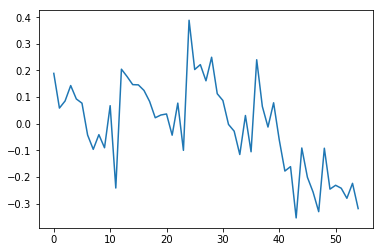

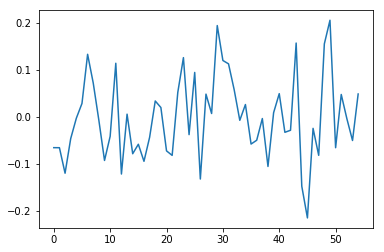

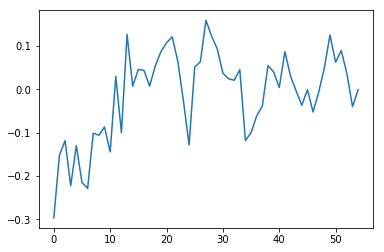

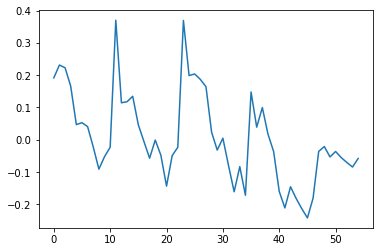

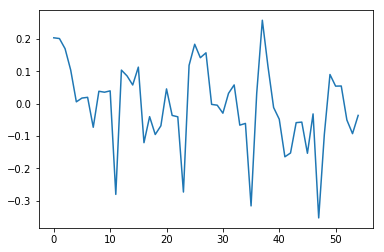

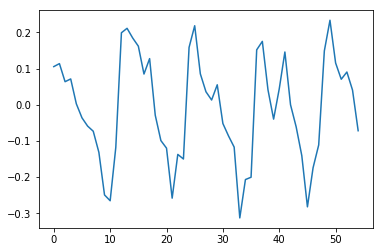

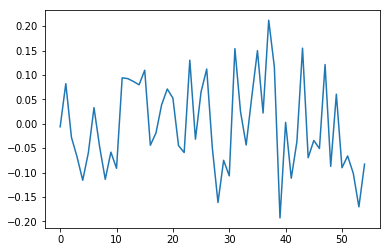

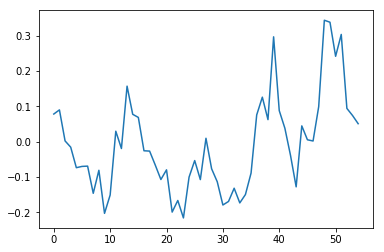

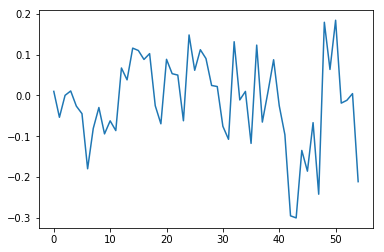

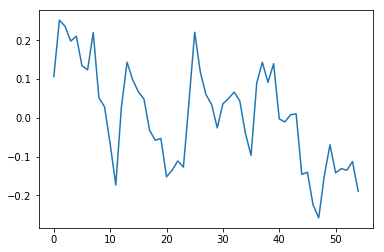

In [171]:
for i in range(10):
    plt.plot(emb_np[6][:,i])
    plt.show()

(array([ 13.,  15.,   4.,   0.,   1.,   0.,   5.,   2.,   2.,   5.]),
 array([-1.73499215, -0.96550061, -0.19600906,  0.57348248,  1.34297402,
         2.11246556,  2.8819571 ,  3.65144864,  4.42094018,  5.19043173,
         5.95992327]),
 <a list of 10 Patch objects>)

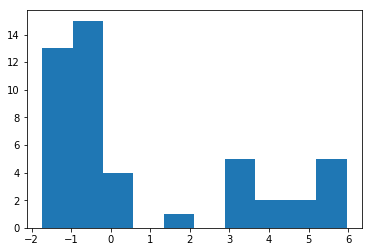

In [177]:
plt.hist(w_np2)

([array([  0.,   0.,   0.,   1.,   2.,  23.,  21.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,  35.,  12.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   5.,  28.,  13.,   1.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,  33.,  12.,   2.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   1.,  32.,  11.,   3.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,  36.,  11.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,  34.,  11.,   2.,   0.,   0.]),
  array([  0.,   0.,   0.,   3.,   3.,  23.,  16.,   1.,   1.,   0.]),
  array([  0.,   0.,   0.,   2.,   2.,  21.,  19.,   2.,   1.,   0.]),
  array([  0.,   0.,   0.,   1.,   4.,  23.,  18.,   1.,   0.,   0.]),
  array([  0.,   0.,   0.,   1.,   3.,  27.,  14.,   2.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   3.,  29.,  15.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   1.,   1.,  31.,  14.,   0.,   0.,   0.]),
  arra

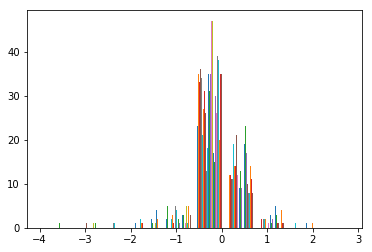

In [178]:
plt.hist(w_np1)